# Installation of libraries

In [ ]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Loading the dataset and Pre-processing

In [2]:

IMAGE_SIZE = (100, 100)  # Adjust size as needed
NUM_CLASSES = 4  # classes- apple,banana,mixed,orange

In [3]:
# Function to parse XML annotations i.e. object class, position of the object
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    objects = []
    for obj in root.findall('object'):
        obj_class = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        objects.append({
            'class': obj_class,
            'bbox': (xmin, ymin, xmax, ymax)
        })
    return objects


In [4]:
#load images and annotations (labelling) from the dataset
def load_dataset(directory):
    images = []
    labels = []
    annotations = {}
    label_map = {}  # Map string labels to numerical categories coz label is in string
    label_index = 0

    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            img_path = os.path.join(directory, filename)
            label = filename.split('_')[0] 
            if label not in label_map:
                label_map[label] = label_index
                label_index += 1
            labels.append(label_map[label])
            image = cv2.imread(img_path)
            image = cv2.resize(image, IMAGE_SIZE)
            annotations[filename] = parse_xml(os.path.join(directory, filename.replace('.jpg', '.xml')))
            images.append(image)

    return np.array(images), np.array(labels), annotations

In [5]:
# Load train and test datasets with the labels
train_images, train_labels, train_annotations = load_dataset(r'C:\Users\eshag\OneDrive\Desktop\Projects\New folder\Object_Recognition\train/')
test_images, test_labels, test_annotations = load_dataset(r'C:\Users\eshag\OneDrive\Desktop\Projects\New folder\Object_Recognition\test/')

In [6]:
print(len(train_labels))

240


In [7]:
# Convert labels to categorical
train_labels = to_categorical(train_labels, num_classes=NUM_CLASSES)
test_labels = to_categorical(test_labels, num_classes=NUM_CLASSES)

In [8]:
# Normalize pixel values to range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Model Building

In [9]:
# Split training data into train and validation sets 70% train, 30% validation
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.3)

# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 33856)             0         
                                                                 
 dense (Dense)               (None, 128)               4

# Model Training

In [11]:
# Train the model
history=model.fit(train_images, train_labels, epochs=10, batch_size=16, validation_data=(val_images, val_labels))
model.save(r'C:\Users\eshag\OneDrive\Desktop\Projects\New folder\Object_Recognition\model.h5')


Epoch 1/10
11/11 [==============================] - 2s 113ms/step - loss: 3.2796 - accuracy: 0.3155 - val_loss: 1.3772 - val_accuracy: 0.2639
Epoch 2/10
11/11 [==============================] - 1s 94ms/step - loss: 1.2596 - accuracy: 0.3869 - val_loss: 1.0814 - val_accuracy: 0.5417
Epoch 3/10
11/11 [==============================] - 1s 102ms/step - loss: 0.9513 - accuracy: 0.6548 - val_loss: 1.0101 - val_accuracy: 0.5417
Epoch 4/10
11/11 [==============================] - 1s 96ms/step - loss: 0.6314 - accuracy: 0.7857 - val_loss: 0.5883 - val_accuracy: 0.7500
Epoch 5/10
11/11 [==============================] - 1s 98ms/step - loss: 0.3592 - accuracy: 0.8810 - val_loss: 0.4453 - val_accuracy: 0.8194
Epoch 6/10
11/11 [==============================] - 1s 90ms/step - loss: 0.2193 - accuracy: 0.9286 - val_loss: 0.4232 - val_accuracy: 0.8750
Epoch 7/10
11/11 [==============================] - 1s 97ms/step - loss: 0.1661 - accuracy: 0.9524 - val_loss: 0.5376 - val_accuracy: 0.7917
Epoch 8/10


# Visulaizing the Evaluating Parameters

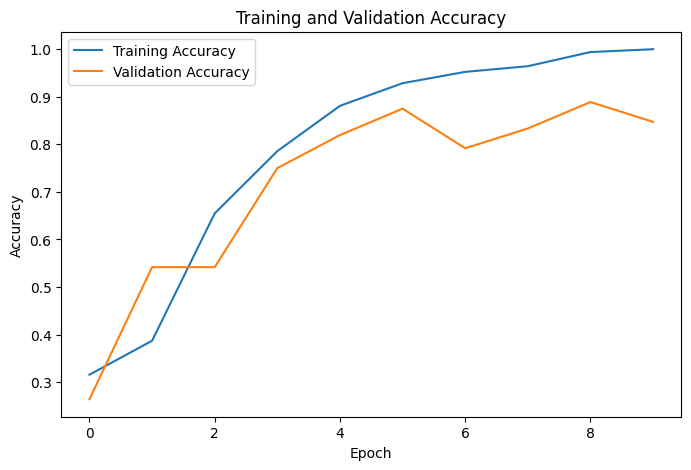

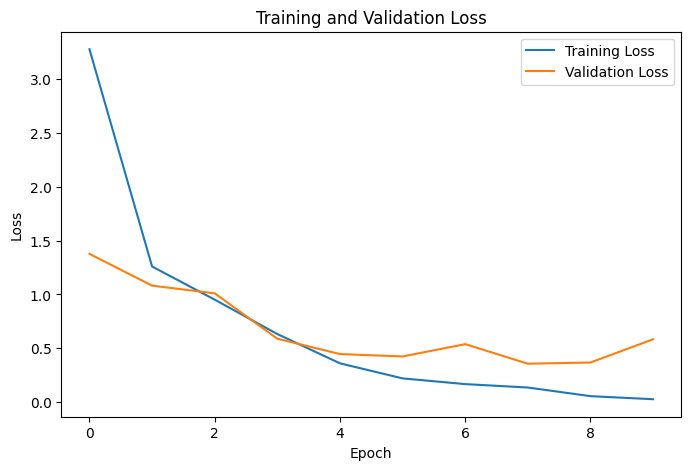

In [12]:


# Plot accuracy over epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation for test dataset

In [13]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy}")

# Make predictions on test set
predictions = model.predict(test_images)

2/2 [==============================] - 0s 21ms/step - loss: 0.8626 - accuracy: 0.8333
Test Accuracy: 0.8333333134651184
2/2 [==============================] - 0s 30ms/step


Accuracy: 0.8333333333333334
Precision: 0.7681159420289856
Recall: 0.8333333333333334
F1 Score: 0.7967479674796748


c:\Users\eshag\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


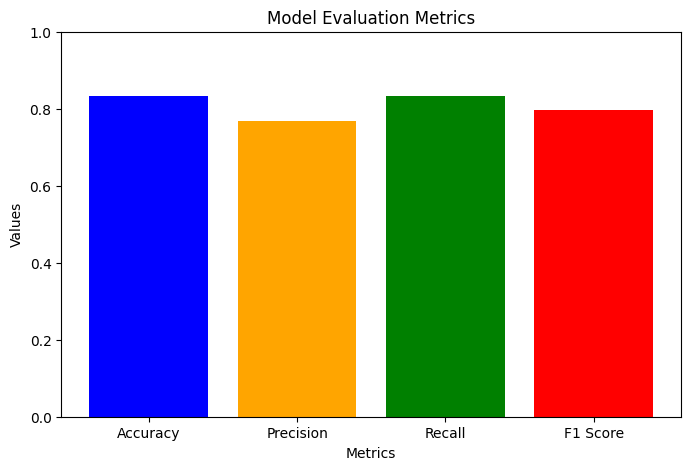

In [14]:


# Convert one-hot encoded test_labels back to categorical labels
true_labels = np.argmax(test_labels, axis=1)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Visualize metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
plt.title('Model Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1)  # Setting the y-axis limit from 0 to 1 for better visualization of accuracy
plt.show()

# Trying on the unknown image (Check data)

1/1 [==============================] - 0s 68ms/step


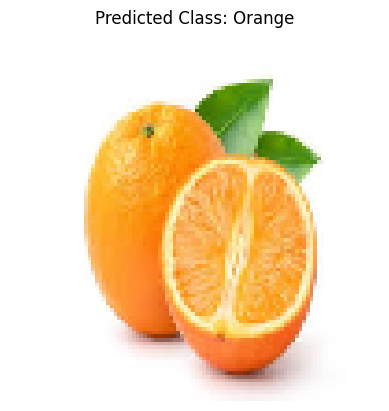

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model(r'C:\Users\eshag\OneDrive\Desktop\Projects\New folder\Object_Recognition\model.h5')  # Replace with the path to your trained model

# Load a single test image for prediction
test_image_path = r'C:\Users\eshag\OneDrive\Desktop\Projects\New folder\Object_Recognition\test_image.jpg'  # Replace with the path to your test image
test_image = cv2.imread(test_image_path)
resized_test_image = cv2.resize(test_image, (100, 100))  # Resize to match model input size
normalized_test_image = resized_test_image / 255.0  # Normalize pixel values

# Reshape image for model prediction
test_input = np.expand_dims(normalized_test_image, axis=0)  # Add batch dimension

# Make predictions
predictions = model.predict(test_input)

# Assuming 'predictions' contains probabilities for each class
class_labels = ['Apple', 'Banana', 'Mixed', 'Orange']  # Replace with your class labels
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]

# Visualize the test image and predicted class
plt.imshow(cv2.cvtColor(resized_test_image, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()
